In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [2]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 120


# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 2000


# Number of weak classifiers
nbrWeakClassifiers = 60




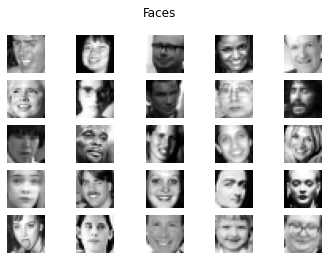

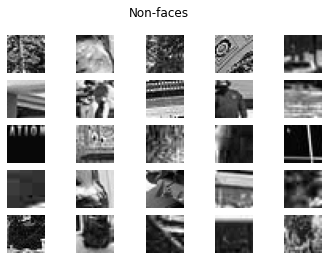

In [3]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

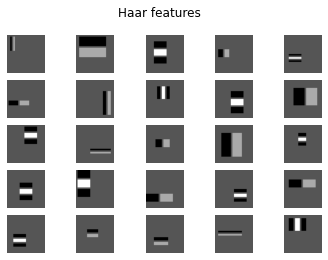

In [4]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [5]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [6]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

def adaboost(X,Y):

    Final_Parameters=[]

    #Initialize sample weights uniformly
    D = [1/nbrTrainImages]*nbrTrainImages

    alphas=[]
    errors=[]
    thresholds =[]
    features=[]
    polarities=[]
    MinC=0


    for NumWeekClass in range(nbrWeakClassifiers):

        MinError=np.inf

        for Haar_index in range(nbrHaarFeatures):


            X= xTrain[Haar_index]
            T= np.unique(X)

            for threshold in T:
                P=1

                C = WeakClassifier(threshold, P, X)
                E = WeakClassifierError(C, D, Y)

                if E > 0.5:
                    E=1-E
                    P=-1

                if E<MinError:
                    MinError=E
                    MinPolarity=P
                    Min_Threshold=threshold
                    Min_Feature =Haar_index
                    Min_C = np.array(C)*P


        alpha = (1/2)*np.log(((1-MinError)/MinError))

        #Update Weights 
        MisClass=(np.not_equal(Y, Min_C)).astype(int)   

        D_new = [D[i]*np.exp(alpha) if c==1 else D[i]*np.exp(-alpha) for i,c in enumerate(MisClass)]

        #Normalize updated weights 
        D=D_new/sum(D_new)

        errors.append(MinError)
        alphas.append(alpha)
        thresholds.append(Min_Threshold)
        features.append(Min_Feature)
        polarities.append(MinPolarity)
        

    Final_Parameters=np.stack((features,thresholds,polarities,alphas,errors))
    return(Final_Parameters)

Final_Parameters=adaboost(xTrain,yTrain) 



#Prints final table with parameters, first row is features, second thresholds, then polarities, alphas and errors
print(Final_Parameters) 



[[ 9.90000000e+01  3.10000000e+01  2.60000000e+01  6.80000000e+01
   1.00000000e+01  4.40000000e+01  6.00000000e+00  9.60000000e+01
   9.80000000e+01  7.00000000e+00  3.30000000e+01  6.00000000e+00
   9.00000000e+01  7.30000000e+01  4.60000000e+01  3.90000000e+01
   9.20000000e+01  4.60000000e+01  7.80000000e+01  4.00000000e+00
   1.04000000e+02  3.50000000e+01  5.50000000e+01  8.30000000e+01
   6.10000000e+01  6.00000000e+00  2.80000000e+01  8.90000000e+01
   4.10000000e+01  4.60000000e+01  5.30000000e+01  6.00000000e+01
   2.80000000e+01  2.70000000e+01  5.00000000e+01  2.00000000e+01
   1.08000000e+02  9.90000000e+01  1.13000000e+02  8.40000000e+01
   1.01000000e+02  1.18000000e+02  8.80000000e+01  5.60000000e+01
   1.09000000e+02  5.80000000e+01  7.00000000e+01  3.10000000e+01
   3.00000000e+00  3.40000000e+01  9.20000000e+01  8.00000000e+01
   5.90000000e+01  1.04000000e+02  6.00000000e+00  6.60000000e+01
   2.60000000e+01  4.50000000e+01  5.30000000e+01  0.00000000e+00]
 [ 1.2680

In [19]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.


def Predicts_adaboost(Final_Parameters,XData,YLabels):    

    WeakClassifiersMatrix= np.zeros( (Final_Parameters.shape[1], XData.shape[1]) )


    for NumWeekClass in range(Final_Parameters.shape[1]):

        feat_index =  int(Final_Parameters[0][NumWeekClass])
        T =  Final_Parameters[1][NumWeekClass]
        P =  Final_Parameters[2][NumWeekClass]
        alpha =  Final_Parameters[3][NumWeekClass]

        WeakClassifiersMatrix[NumWeekClass]= (alpha*np.array(WeakClassifier(T, P, XData[feat_index])))

    Prediction = np.sign(np.sum(WeakClassifiersMatrix, axis=0))
    
    accuracy = np.sum(YLabels == Prediction) / len(YLabels)
    
    WeakClassMatrix = WeakClassifiersMatrix
    
    
    return(round(accuracy,3),Prediction,WeakClassMatrix)


accuracy_trainData,Predicts_TrainData, WeakClassMatrix_TrainData= Predicts_adaboost(Final_Parameters,xTrain,yTrain )

print("\nPrediction on Training data:", accuracy_trainData)

accuracy_testData,Predicts_TestData,WeakClassMatrix_TestData= Predicts_adaboost(Final_Parameters,xTest,yTest )

print("\nPrediction on Test data:", accuracy_testData)


Prediction on Training data: 0.978

Prediction on Test data: 0.95



 2000 images were used for training data:
 -> 1000 faces and 1000 non-faces


10788 images were used for test data:
 -> 3916 faces and 6872 non-faces



120 Haar features and 60 Weak classifiers were used to compute one strong classifier.



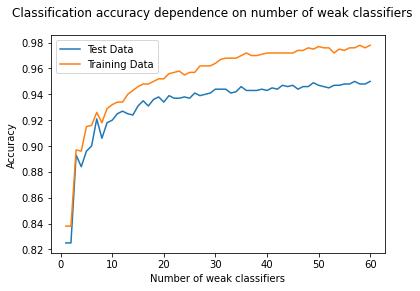

In [40]:
#  Plot how the classification accuracy on training data and test data depend on the number of weak
# classifiers (in the same plot). 

Accuracy_testdata = []
Accuracy_trainingdata = []

for NumWeekClass in range(Final_Parameters.shape[1]):
    accuracy_test,Predicts,Wctest= Predicts_adaboost(Final_Parameters[:, :(NumWeekClass+1)],xTest,yTest )
    accuracy_train,Predicts,Wctrain= Predicts_adaboost(Final_Parameters[:, :(NumWeekClass+1)],xTrain,yTrain )
    Accuracy_testdata.append(accuracy_test)
    Accuracy_trainingdata.append(accuracy_train)

plt.plot(list(range(1,nbrWeakClassifiers+1)), Accuracy_testdata, label="Test Data")
plt.plot(list(range(1,nbrWeakClassifiers+1)), Accuracy_trainingdata, label="Training Data")
plt.legend()
plt.suptitle('Classification accuracy dependence on number of weak classifiers')
plt.xlabel('Number of weak classifiers')
plt.ylabel('Accuracy')

    
print("\n",yTrain.shape[0], "images were used for training data:\n","->",np.array(np.where(yTrain==1)).size,"faces and",np.array(np.where(yTrain==-1)).size,"non-faces")
print("\n")
print(yTest.shape[0], "images were used for test data:\n","->",np.array(np.where(yTest==1)).size,"faces and",np.array(np.where(yTest==-1)).size,"non-faces\n")
print("\n")
print(nbrHaarFeatures,"Haar features and",nbrWeakClassifiers, "Weak classifiers were used to compute one strong classifier.\n")


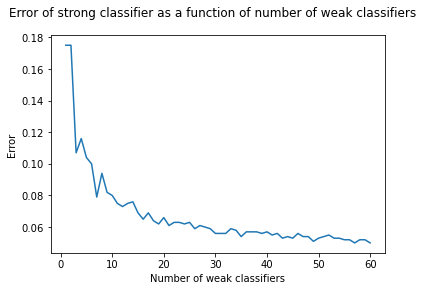

In [15]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.
Error_StrongClass = []
for NumWeekClass in range(1,nbrWeakClassifiers+1):
    accuracy,Predicts= Predicts_adaboost(Final_Parameters[:, :(NumWeekClass)],xTest,yTest )
    Error_StrongClass.append(1-accuracy)


plt.plot(list(range(1,nbrWeakClassifiers+1)), Error_StrongClass)
plt.ylabel("Error")
plt.xlabel("Number of weak classifiers")
plt.suptitle("Error of strong classifier as a function of number of weak classifiers")
plt.show()



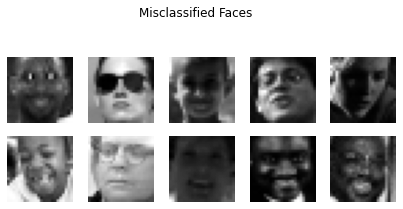

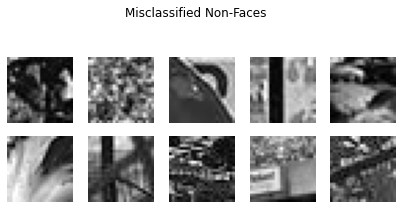




Additionaly, here are some of the well classified faces and non-faces:



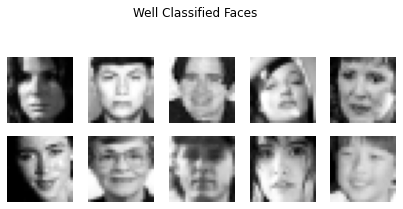

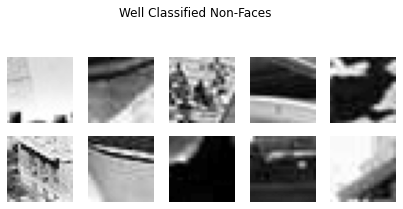

In [12]:
# # Plot some of the misclassified faces and non-faces
# # Use the subplot command to make nice figures with multiple images.


Misclass_Faces=[]
Misclass_NonFaces =[]
WellClassified_Faces=[]
WellClassified_NonFaces=[]


for i in range(len(yTest)):
    if yTest[i]!=Predicts_TestData[i] and yTest[i]==1:
        Misclass_Faces.append(i)
        
    if yTest[i]!=Predicts_TestData[i] and yTest[i]==-1:
        Misclass_NonFaces.append(i)
        
        
        
for i in range(len(yTest)):
    if yTest[i]==Predicts_TestData[i] and yTest[i]==1:
        WellClassified_Faces.append(i)
        
    if yTest[i]==Predicts_TestData[i] and yTest[i]==-1:
        WellClassified_NonFaces.append(i)
        
        
        
First10MisclassFaces=Misclass_Faces[:10]
First10MisclassNonFaces=Misclass_NonFaces[:10]
First10WellClassFaces=WellClassified_Faces[:10]
First10WellClassNonFaces=WellClassified_NonFaces[:10]



plt.figure(figsize=(7, 7))
for i,c in enumerate(First10MisclassFaces):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,c], cmap='gray')
    plt.axis('off')
plt.suptitle('Misclassified Faces')
plt.show()
print("\n")

plt.figure(figsize=(7, 7))
for i,c in enumerate(First10MisclassNonFaces):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,c], cmap='gray')
    plt.axis('off')
plt.suptitle('Misclassified Non-Faces')
plt.show()
print("\n")
print("\nAdditionaly, here are some of the well classified faces and non-faces:\n")



plt.figure(figsize=(7, 7))
for i,c in enumerate(First10WellClassFaces):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,c], cmap='gray')
    plt.axis('off')
plt.suptitle('Well Classified Faces')
plt.show()
print("\n")

plt.figure(figsize=(7, 7))
for i,c in enumerate(First10WellClassNonFaces):
    plt.subplot(5,5,i+1)
    plt.imshow(testImages[:,:,c], cmap='gray')
    plt.axis('off')
plt.suptitle('Well Classified Non-Faces')
plt.show()


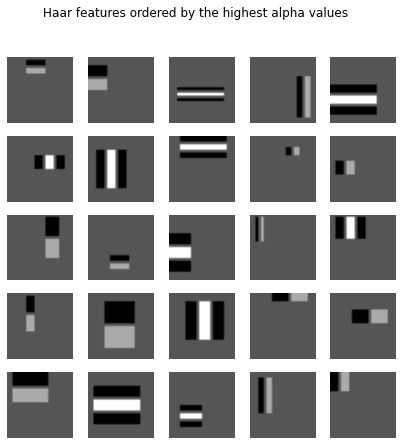

In [134]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.    

#Sort features by the alpha values (features with higher alphas are features that contribute more to the prediction)
Sorted_Features = Final_Parameters[:, Final_Parameters[3, :].argsort()][0]


First25Features=Sorted_Features[:25]

plt.figure(figsize=(7, 7))
for c,k in enumerate(First25Features):
    plt.subplot(5,5,c+1)
    plt.imshow(haarFeatureMasks[:,:,int(k)], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features ordered by the highest alpha values')
plt.show()


feature 59 - weak class 52
feature 53 - weak class 30
feature 92 - weak class 16
feature 6 - weak class 6
feature 66 - weak class 55




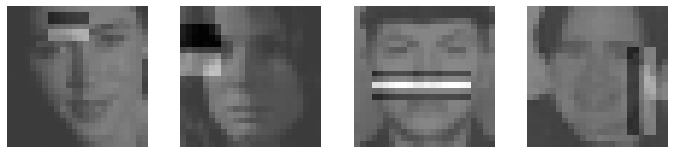

In [156]:
#Weak Classifier 52 selected feature 59
print("feature", int(First25Features[:5][0]),"- weak class", list(Final_Parameters[0]).index(First25Features[:5][0]))

# #Weak Classifier 30 selected feature 53
print("feature", int(First25Features[:5][1]),"- weak class", list(Final_Parameters[0]).index(First25Features[:5][1]))


# #Weak Classifier 16 selected feature 92
print("feature", int(First25Features[:5][2]),"- weak class", list(Final_Parameters[0]).index(First25Features[:5][2]))

# #Weak Classifier 6 selected feature 6
print("feature", int(First25Features[:5][3]),"- weak class", list(Final_Parameters[0]).index(First25Features[:5][3]))

# #Weak Classifier 55 selected feature 66
print("feature", int(First25Features[:5][4]),"- weak class", list(Final_Parameters[0]).index(First25Features[:5][4]))



#Weak classifier 52 (that uses feature 59) is positively contributing to predict test image 8
#WeakClassMatrix_TestData[52][8]

#Weak classifier 30 (that uses feature 53) is positively contributing to predict test image 0 (also 1 and 2)
#WeakClassMatrix_TestData[30][0]

#Weak classifier 16 (that uses feature 92) is positively contributing to predict test image 1 (also 0, 2,4)
#WeakClassMatrix_TestData[16][1]


#Weak classifier 6 (that uses feature 6) is positively contributing to predict test image 2
#WeakClassMatrix_TestData[6][2]

print("\n")

testImagesPlot=[8,0,1,2]
feat=First25Features[:4]

plt.figure(figsize=(15, 15))
plt.subplot(5,5,1)
plt.imshow(testImages[:,:,testImagesPlot[0]], cmap='gray',interpolation='nearest')
plt.imshow(haarFeatureMasks[:,:,int(feat[0])],cmap='gray', vmin=-1, vmax=2, alpha=0.7)
plt.axis('off')

plt.subplot(5,5,2)
plt.imshow(testImages[:,:,testImagesPlot[1]], cmap='gray',interpolation='nearest')
plt.imshow(haarFeatureMasks[:,:,int(feat[1])],cmap='gray', vmin=-1, vmax=2, alpha=0.7)
plt.axis('off')

plt.subplot(5,5,3)
plt.imshow(testImages[:,:,testImagesPlot[2]], cmap='gray',interpolation='nearest')
plt.imshow(haarFeatureMasks[:,:,int(feat[2])],cmap='gray', vmin=-1, vmax=2, alpha=0.7)
plt.axis('off')

plt.subplot(5,5,4)
plt.imshow(testImages[:,:,testImagesPlot[3]], cmap='gray',interpolation='nearest')
plt.imshow(haarFeatureMasks[:,:,int(feat[3])],cmap='gray', vmin=-1, vmax=2, alpha=0.7)
plt.axis('off')
plt.show()

